# **Read file**

In [1]:
# Import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
import plotly.graph_objects as go
from matplotlib.lines import Line2D



In [2]:
#drive.mount('/content/drive')
file_path = '1305.csv'
df = pd.read_csv(file_path)
df.keys()

Index(['Volunteer number', 'Session (1, 2)',
       'Condition (PLA: placebo, EXP: 25 mg/70 kg psilocybi)',
       'Timepoint relative to drug administration (in minutes)',
       '1. Overall Psilocybin Effect (0 = none to\n10 = strongest imaginable)',
       '2. Now-ness (0 = none to\n10 = strongest imaginable)  ',
       '3. Letting Go (0 = none to\n10 = strongest imaginable)',
       '4. Equanimity (0 = none to\n10 = strongest imaginable)',
       '5. Pure being and pure awareness (0 = none to\n10 = strongest imaginable)',
       '6. Fusion of your personal self into a larger whole (0 = none to\n10 = strongest imaginable)',
       '7. Sense of reverence or sacredness (0 = none to\n10 = strongest imaginable)',
       '8. Timelessness (0 = none to\n10 = strongest imaginable)',
       '9. Ineffability (0 = none to\n10 = strongest imaginable)',
       '10. Feelings of joy (0 = none to\n10 = strongest imaginable)',
       '11. Feelings of peace and tranquility (0 = none to\n10 = stronges

# **Preprocess**

In [3]:
# Remove the columns "Unnamed: 17" and "Unnamed: 18"
if 'Unnamed: 17' in df.columns:
  df = df.drop('Unnamed: 17', axis=1)
if 'Unnamed: 18' in df.columns:
  df = df.drop('Unnamed: 18', axis=1)

In [4]:
def remove_ms_feature(features, timepoints, vol_num, condition):
      # prompt: if a row of features contains 'ms', save that index and remove
      remove_idx = []
      for i in range(features.shape[0]):
        for j in range(features.shape[1]):
          if type(features[i,j]) == str and 'ms' in features[i,j]:
            remove_idx.append(i)

      features = np.delete(features, remove_idx, axis=0)
      timepoints = np.delete(timepoints, remove_idx, axis=0)
      vol_num = np.delete(vol_num, remove_idx, axis=0)
      condition = np.delete(condition, remove_idx, axis=0)
      timepoints[timepoints == 'baseline'] = -20

      return features, timepoints, vol_num, condition


def create_matrix():

      # read df from csv
      df = pd.read_csv(file_path)

      print(f"dataframe shape: ",df.shape)
      # interplot the ms datapoints
      # if interplot_or_delete == 'interplot':
      #    feature_names = [df.keys()[i] for i in range(4,17)]
      #    temp = interplotting(df, feature_names)
      #    df[feature_names]= temp



      # create feature matrix in np.array
      vol_num = df[df.keys()[0]]
      condition = df[df.keys()[2]]
      timepoints = df[df.keys()[3]]
      feat1 = df[df.keys()[4]]
      feat2 = df[df.keys()[5]]
      feat3 = df[df.keys()[6]]
      feat4 = df[df.keys()[7]]
      feat5 = df[df.keys()[8]]
      feat6 = df[df.keys()[9]]
      feat7 = df[df.keys()[10]]
      feat8 = df[df.keys()[11]]
      feat9 = df[df.keys()[12]]
      feat10 = df[df.keys()[13]]
      feat11 = df[df.keys()[14]]
      feat12 = df[df.keys()[15]]
      feat13 = df[df.keys()[16]]

      # Delete rows corresponds to average measurements
      idx = [i for i in range(len(timepoints)) if (timepoints[i] != 'Avg from capsule to 360')]

      vol_num = vol_num[idx]
      condition = condition[idx]
      timepoints = timepoints[idx]
      feat1 = feat1[idx]
      feat2 = feat2[idx]
      feat3 = feat3[idx]
      feat4 = feat4[idx]
      feat5 = feat5[idx]
      feat6 = feat6[idx]
      feat7 = feat7[idx]
      feat8 = feat8[idx]
      feat9 = feat9[idx]
      feat10 = feat10[idx]
      feat11 = feat11[idx]
      feat12 = feat12[idx]
      feat13 = feat13[idx]

      features = np.stack([feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9, feat10, feat11, feat12, feat13])
      features = features.T

      print(f"matrix shape before delete: ",features.shape)

      # if interplot_or_delete=='delete':
      features, timepoints, vol_num, condition = remove_ms_feature(features, timepoints, vol_num, condition)

      print(f"matrix shape after delete: ",features.shape)
      return features, timepoints, vol_num, condition

features, timepoints, vol_num, condition = create_matrix()
features.shape

dataframe shape:  (610, 19)
matrix shape before delete:  (549, 13)
matrix shape after delete:  (471, 13)


(471, 13)

In [5]:
# Convert elements in timepoints, vol_num, to int
timepoints = [int(tp) if isinstance(tp, str) and tp.isdigit() else tp for tp in timepoints]
vol_num = [int(vn) for vn in vol_num]

# Convert elements in features to int (if possible)
for i in range(features.shape[0]):
  for j in range(features.shape[1]):
    if isinstance(features[i, j], str) and features[i, j].isdigit():
      features[i, j] = int(features[i, j])

features.dtype

dtype('O')

In [6]:
questions = df.keys()[4:]
questions = [question.split('(')[0].strip() for question in questions]
questions

['1. Overall Psilocybin Effect',
 '2. Now-ness',
 '3. Letting Go',
 '4. Equanimity',
 '5. Pure being and pure awareness',
 '6. Fusion of your personal self into a larger whole',
 '7. Sense of reverence or sacredness',
 '8. Timelessness',
 '9. Ineffability',
 '10. Feelings of joy',
 '11. Feelings of peace and tranquility',
 '12. Positive Emotional Valence',
 '13. Negative emotional valence']

In [7]:
# Change elements in list 'condition'. PLA ->Placebo-A, PSIL -> Psilocybin-A, and EXP -> Psilocybin-B

condition = np.array([
    "Placebo-A" if x == "PLA" else
    "Psilocybin-B" if x == "PSIL" else
    "Psilocybin-A" if x == "EXP" else
    x for x in condition
])

timepoints = np.array(timepoints)

# **PCA Analysis**

## Reshape numpy arrays for pca

In [8]:
# features
timepoints_id = [i for i in range(len(timepoints)) if timepoints[i] == -20]
response_collection = []

# iterate over questions
for i in range(features.shape[1]):
    # extract question info
    response_delete = features[:,i]


    rows = []
    condition_reshaped = []
    vol_num_reshaped = []

    # iterate over feature_delete, delete individuals that has lower than 8 datapints
    for i in range(len(timepoints_id)-1):
        if timepoints_id[i+1] - timepoints_id[i] == 8:
            temp = response_delete[timepoints_id[i]:timepoints_id[i+1]]
            rows.append(temp)

            # keep track of condition after reshaped
            condition_reshaped.append(condition[timepoints_id[i]])
            vol_num_reshaped.append(vol_num[timepoints_id[i]])


    response_collection.append(np.array(rows))

# convert list to np arrays

feature_reshaped = np.array(response_collection)
condition_reshaped = np.array(condition_reshaped)


print(feature_reshaped.shape)
print(condition_reshaped.shape)


(13, 50, 8)
(50,)


In [9]:
vol_num_reshaped = np.array(vol_num_reshaped)
vol_num_reshaped

array([708, 709, 710, 710, 716, 722, 722, 727, 730, 730, 732, 732, 733,
       733, 738, 739, 740, 740, 742, 743, 744, 745, 745, 746, 746, 751,
       752, 752, 753, 754, 755, 758, 758, 761, 762, 763, 763, 765, 767,
       767, 768, 768, 769, 769, 771, 771, 772, 775, 775, 776])

## PCA results with same vol_number individuals connected

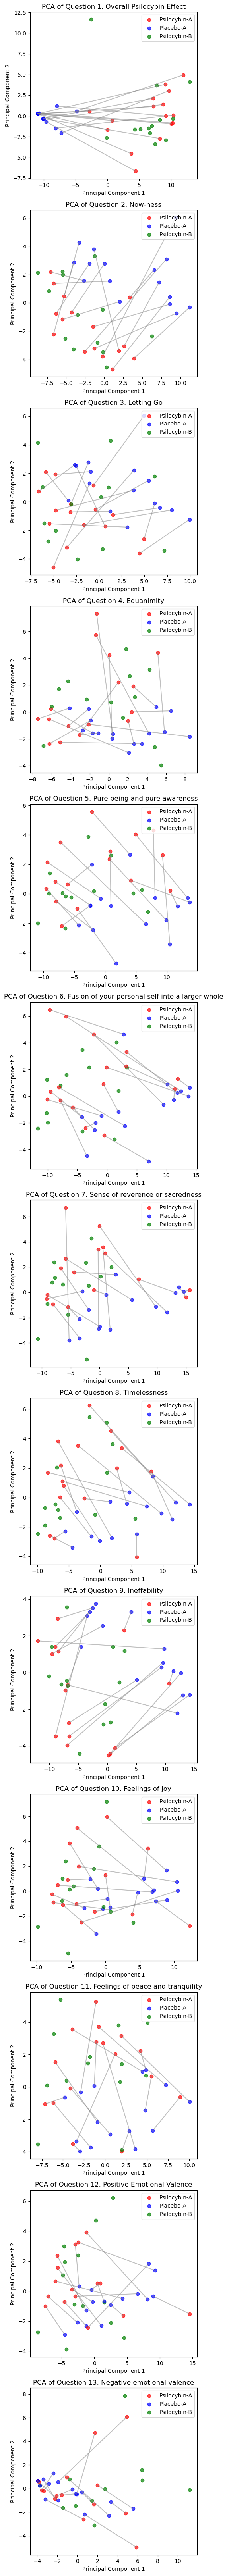

In [10]:
# Perform pca on features for each 13 questions.
# After performing pca, plot the spots, and connect the points that has the same vol_num value in vol_num_reshaped.
# Set legend to either 'EXP', 'PLA', or 'PSIL', do not display the vol_num in legend. And for each connected dots, one should be 'PLA', and the other should be 'EXP'.
# Distinguish them in color. Then, add the 'PSIL' to the plot, which should not be connected

# Define the palette for plotting
palette = {'Placebo-A': 'blue', 'Psilocybin-A': 'red', 'Psilocybin-B': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(13, 1, figsize=(8, 65))  # 13 rows, 1 column

# Loop through each question (feature)
for i in range(13):
    # Extract data for the current question
    data = feature_reshaped[i]

    # Perform PCA on features_interplot
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Plot for features_interplot (left side)
    unique_vol_nums = np.unique(vol_num_reshaped)
    for vol_num in unique_vol_nums:
        indices = np.where(vol_num_reshaped == vol_num)[0]
        if len(indices) > 0:
            # Find the condition for the first index of this vol_num
            condition_for_vol_num = condition_reshaped[indices]
            # Check if there are both 'EXP' and 'PLA' conditions for this vol_num
            if 'Psilocybin-A' in condition_for_vol_num and 'Placebo-A' in condition_for_vol_num:
                exp_indices = [idx for idx in indices if condition_reshaped[idx] == 'Psilocybin-A']
                pla_indices = [idx for idx in indices if condition_reshaped[idx] == 'Placebo-A']

                if exp_indices and pla_indices:
                    # Find the exp and pla indices for vol_num
                    exp_index = exp_indices[0]
                    pla_index = pla_indices[0]

                    # Plot the points
                    axes[i].scatter(pca_result[exp_index, 0], pca_result[exp_index, 1],
                                      c=palette['Psilocybin-A'], label='Psilocybin-A', alpha=0.7)
                    axes[i].scatter(pca_result[pla_index, 0], pca_result[pla_index, 1],
                                      c=palette['Placebo-A'], label='Placebo-A', alpha=0.7)

                    # Connect the points with a line
                    axes[i].plot([pca_result[exp_index, 0], pca_result[pla_index, 0]],
                                   [pca_result[exp_index, 1], pca_result[pla_index, 1]],
                                   color='gray', alpha=0.5)


            # Plot PSIL points without connecting
            psil_indices = [idx for idx in indices if condition_reshaped[idx] == 'Psilocybin-B']
            if psil_indices:
                axes[i].scatter(pca_result[psil_indices, 0], pca_result[psil_indices, 1],
                                  c=palette['Psilocybin-B'], label='Psilocybin-B', alpha=0.7)



    axes[i].set_title(f'PCA of Question {questions[i]}')
    axes[i].set_xlabel('Principal Component 1')
    axes[i].set_ylabel('Principal Component 2')
    axes[i].set_box_aspect(1)

    # Remove duplicate labels from legend
    handles, labels = axes[i].get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    axes[i].legend(unique_handles, unique_labels, loc='upper right')



# Adjust layout and show the figure
plt.tight_layout()
plt.show()

## Juxtapose PCA with k-means clustering

### *K=2*

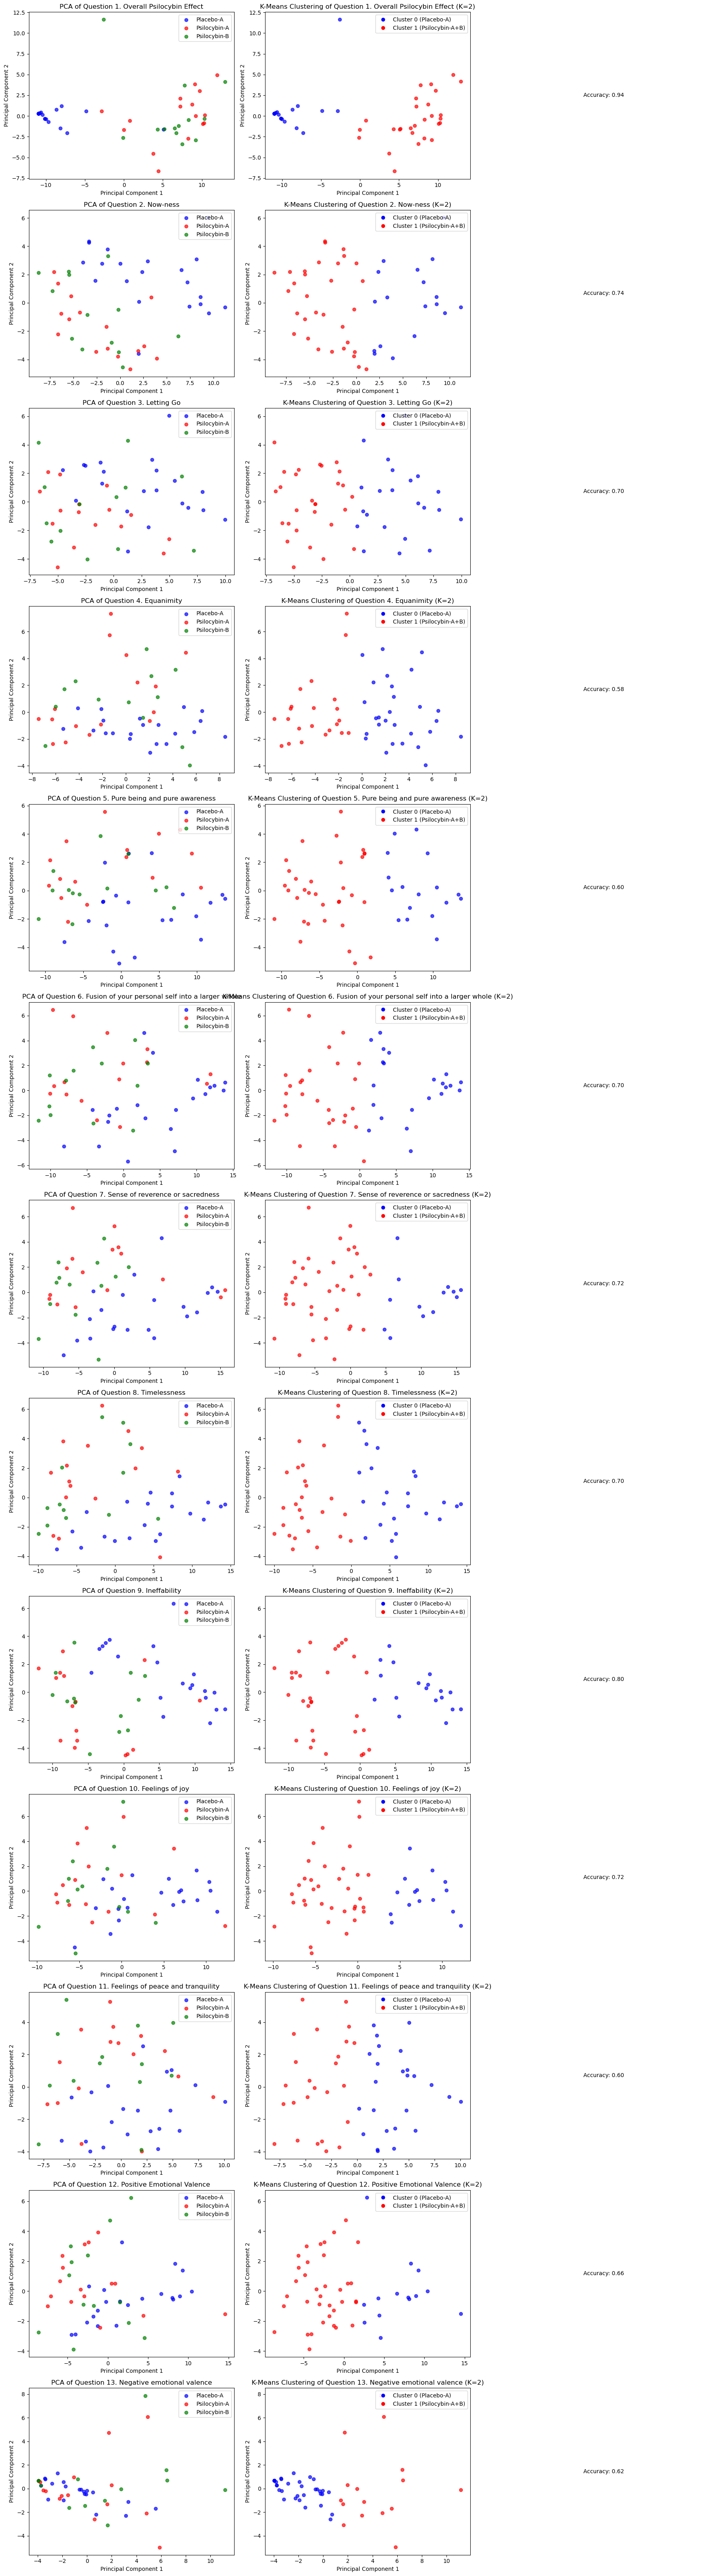

In [11]:
# Perform pca and k-means (k=2) clustering. Plot pca, 'PLA' class in blue, and 'EXP'+'PSIL' in red.  After k-means clustering, make a rotation for each cluster matching each class (class1 PLA, class2: EXP+PSIL) to find the best match that has highest classifying accuracy. Then, plot the k-means clustering, the color should be the same as pca plot, with reference of best match. Then, calculate the accuracy for each question's classification. Make sure the legend of cluster result color matches the color of the dots, blue: cluster0 (PLA), red: cluster1 (EXP+PSIL)

# Define the palette for plotting
# palette = {'Placebo-A': 'blue', 'Psilocybin-A': 'red', 'Psilocybin-B': 'green'}
accuracies2 = []

# Create a figure with subplots
fig, axes = plt.subplots(13, 3, figsize=(18, 65))  # 13 rows, 3 columns

# Loop through each question (feature)
for i in range(13):
    # Extract data for the current question
    data = feature_reshaped[i]

    # Perform PCA on features_interplot
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Plot for features_interplot (left side)
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i, 0].scatter(pca_result[indices, 0], pca_result[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i, 0].set_title(f'PCA of Question {questions[i]}')
    axes[i, 0].set_xlabel('Principal Component 1')
    axes[i, 0].set_ylabel('Principal Component 2')
    axes[i, 0].legend(loc='upper right')


    # Perform K-Means clustering on PCA result of features_interplot
    n_clusters = 2  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(pca_result)

    # Find the best match between clusters and classes (PLA, EXP+PSIL)
    true_labels = [1 if c == 'Placebo-A' else 0 for c in condition_reshaped]
    best_accuracy = 0
    best_mapping = None

    for mapping in [(0, 1), (1, 0)]:
        predicted_labels = [mapping[c] for c in clusters]
        accuracy = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred]) / len(true_labels)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = mapping


    # Plot K-means clusters (middle side) with the best mapping
    cluster_colors = ['blue' if best_mapping[c] == 1 else 'red' for c in clusters]  # Adjust mapping
    axes[i, 1].scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_colors, alpha=0.7)


    axes[i, 1].set_title(f'K-Means Clustering of Question {questions[i]} (K=2)')
    axes[i, 1].set_xlabel('Principal Component 1')
    axes[i, 1].set_ylabel('Principal Component 2')

    # Add legend for clusters
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Cluster 0 (Placebo-A)', markerfacecolor='blue', markersize=8),
                       plt.Line2D([0], [0], marker='o', color='w', label='Cluster 1 (Psilocybin-A+B)', markerfacecolor='red', markersize=8)]

    axes[i, 1].legend(handles=legend_elements, loc='upper right')

    # Calculate and plot accuracy
    predicted_labels = [best_mapping[c] for c in clusters]
    accuracy = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred]) / len(true_labels)
    accuracies2.append(accuracy)
    axes[i, 2].text(0.5, 0.5, f'Accuracy: {accuracy:.2f}', ha='center', va='center')
    axes[i, 2].axis('off')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

### *k=3*

Accuracy for Question 1 (PLA classification): 0.94
Accuracy for Question 2 (PLA classification): 0.74
Accuracy for Question 3 (PLA classification): 0.74
Accuracy for Question 4 (PLA classification): 0.74
Accuracy for Question 5 (PLA classification): 0.66
Accuracy for Question 6 (PLA classification): 0.74
Accuracy for Question 7 (PLA classification): 0.66
Accuracy for Question 8 (PLA classification): 0.78
Accuracy for Question 9 (PLA classification): 0.78
Accuracy for Question 10 (PLA classification): 0.72
Accuracy for Question 11 (PLA classification): 0.64
Accuracy for Question 12 (PLA classification): 0.70
Accuracy for Question 13 (PLA classification): 0.62


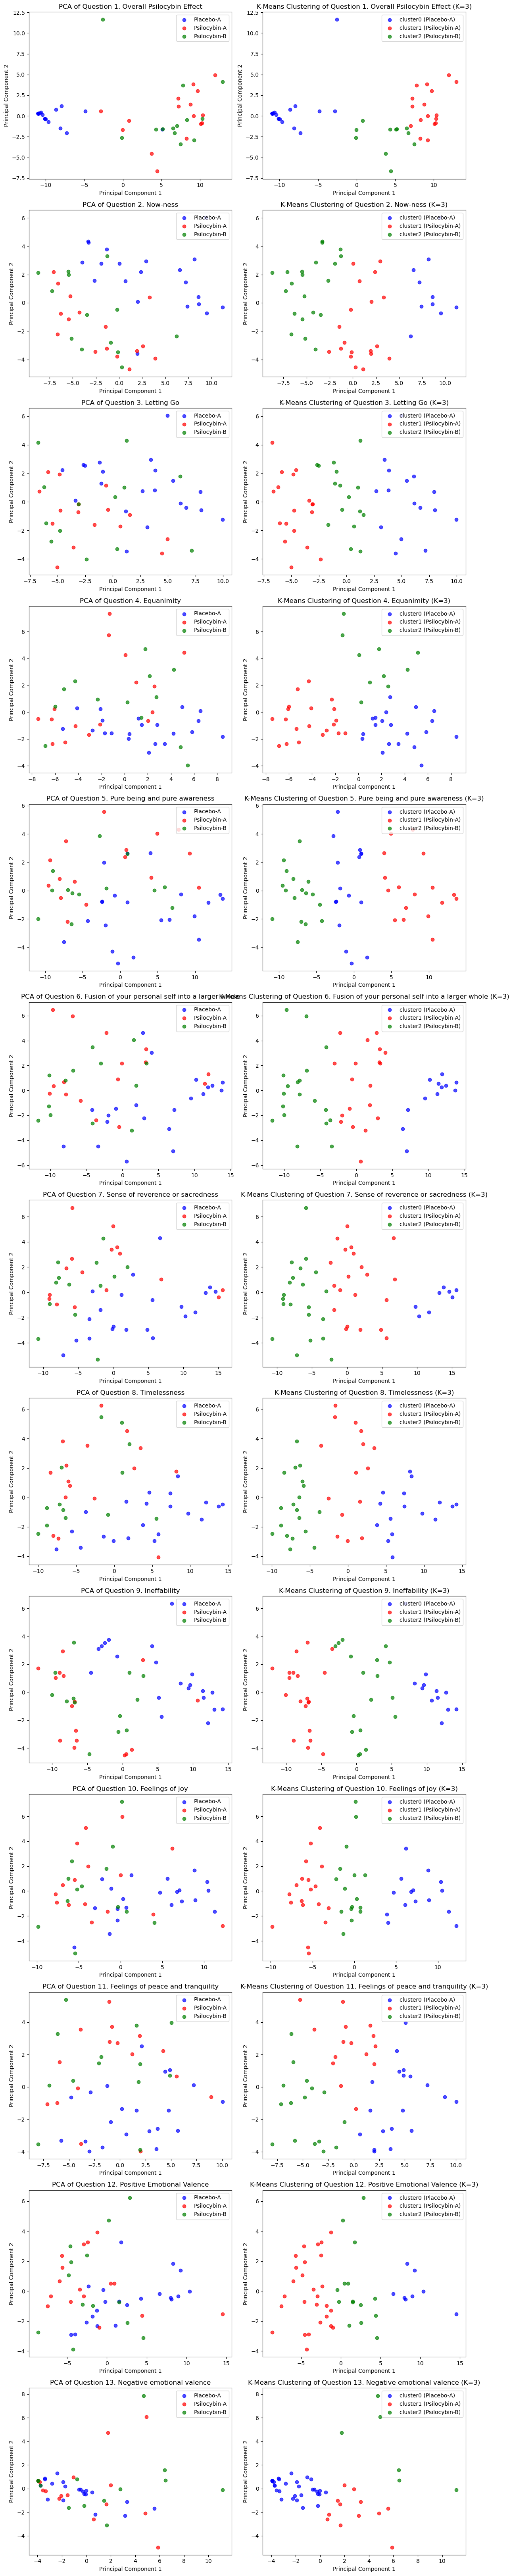

In [12]:
# Perform pca and k-means (k=3) clustering. Plot pca, 'PLA' class in blue, and 'EXP'+'PSIL' in red.  After k-means clustering, make a rotation for each cluster matching each class (class1 PLA, class2: EXP, class3: PSIL) to find the best match that has highest classifying accuracy. Then, plot the k-means clustering, the color should be the same as pca plot, with reference of best match. Then, calculate the accuracy for each question's classification (the cluster matches PLA, and combine the other two clusters to match EXP+PSIL)
# palette = {'Placebo-A': 'blue', 'Psilocybin-A': 'red', 'Psilocybin-B': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(13, 2, figsize=(12, 65))  # 13 rows, 2 columns
accuracies3 = []
# Loop through each question (feature)
for i in range(13):
    # Extract data for the current question
    data = feature_reshaped[i]

    # Perform PCA on features
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)

    # Plot for features (left side)
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i, 0].scatter(pca_result[indices, 0], pca_result[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i, 0].set_title(f'PCA of Question {questions[i]}')
    axes[i, 0].set_xlabel('Principal Component 1')
    axes[i, 0].set_ylabel('Principal Component 2')
    axes[i, 0].legend(loc='upper right')

    # Perform K-Means clustering on PCA result of features_interplot
    n_clusters = 3  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(pca_result)

    # Find the best match for cluster labels to conditions (PLA, EXP, PSIL)
    best_accuracy = 0
    best_mapping = None
    for mapping in [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]:
        predicted_labels = np.where(clusters == mapping[0], 'Placebo-A',
                                    np.where(clusters == mapping[1], 'Psilocybin-B', 'Psilocybin-A'))
        accuracy = accuracy_score(condition_reshaped, predicted_labels)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = mapping

    # Plot K-means clusters (right side) with best mapping
    if best_mapping:
        predicted_labels = np.where(clusters == best_mapping[0], 'Placebo-A',
                                    np.where(clusters == best_mapping[1], 'Psilocybin-B', 'Psilocybin-A'))
        for label in np.unique(predicted_labels):
            indices = np.where(predicted_labels == label)[0]
            axes[i, 1].scatter(pca_result[indices, 0], pca_result[indices, 1],
                               c=palette[label], label=label, alpha=0.7)

    axes[i, 1].set_title(f'K-Means Clustering of Question {questions[i]} (K=3)')
    axes[i, 1].set_xlabel('Principal Component 1')
    axes[i, 1].set_ylabel('Principal Component 2')


    # Calculate accuracy for PLA classification (cluster matches PLA, combine other two clusters to match EXP+PSIL)
    if best_mapping:
        predicted_labels = np.where(clusters == best_mapping[0], 'Placebo-A', 'Psilocybin-A+B')
        accuracy = accuracy_score(np.where(condition_reshaped == 'Placebo-A', 'Placebo-A', 'Psilocybin-A+B'), predicted_labels)
        print(f"Accuracy for Question {i+1} (PLA classification): {accuracy:.2f}")
    accuracies3.append(accuracy)
    # axes[i, 2].text(0.5, 0.5, f'Accuracy: {accuracy:.2f}', ha='center', va='center')
    # axes[i, 2].axis('off')

    # Add legend for clusters
    handles, labels = axes[i, 1].get_legend_handles_labels()
    unique_labels = ['cluster0 (Placebo-A)','cluster1 (Psilocybin-A)', 'cluster2 (Psilocybin-B)']
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            #unique_labels.append(label)
            unique_handles.append(handle)
    axes[i, 1].legend(unique_handles, unique_labels, loc='upper right')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [13]:
questions

['1. Overall Psilocybin Effect',
 '2. Now-ness',
 '3. Letting Go',
 '4. Equanimity',
 '5. Pure being and pure awareness',
 '6. Fusion of your personal self into a larger whole',
 '7. Sense of reverence or sacredness',
 '8. Timelessness',
 '9. Ineffability',
 '10. Feelings of joy',
 '11. Feelings of peace and tranquility',
 '12. Positive Emotional Valence',
 '13. Negative emotional valence']

In [14]:
# count number of pla in condition_reshaped

pla_count = np.sum(condition_reshaped == 'Placebo-A')
print(f"Number of 'PLA' in condition_reshaped: {pla_count}")

Number of 'PLA' in condition_reshaped: 21


### *Plot accuracy*

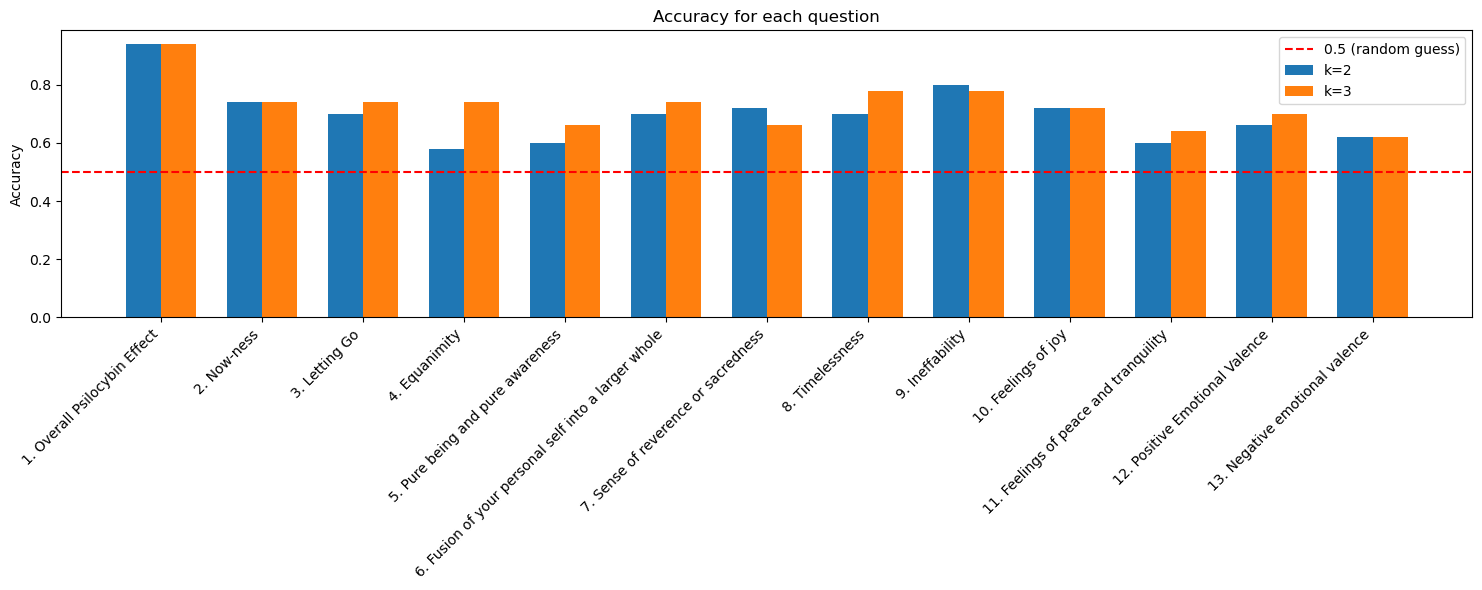

In [15]:
# Plot the accuracies for each question contained in list question. accuracy scores stored in accuracies2 and accuracies3. plot them in bar graphs. Legend set score in accuracies2 as k=2, accuracies3 as k=3, draw a threshold line at 0.58

x = np.arange(len(questions))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust figure size as needed
rects1 = ax.bar(x - width / 2, accuracies2, width, label='k=2')
rects2 = ax.bar(x + width / 2, accuracies3, width, label='k=3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for each question')
ax.set_xticks(x, questions, rotation=45, ha='right')


# Add a horizontal line at 0.58
ax.axhline(y=0.50, color='red', linestyle='--', label='0.5 (random guess)')

ax.legend()

# Adjust layout and show the figure
fig.tight_layout()
plt.show()

# **Varimax Rotation**

In [16]:
from factor_analyzer import Rotator

In [17]:
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd

def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in list(range(q)):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

rotated_components = varimax(pca_result)

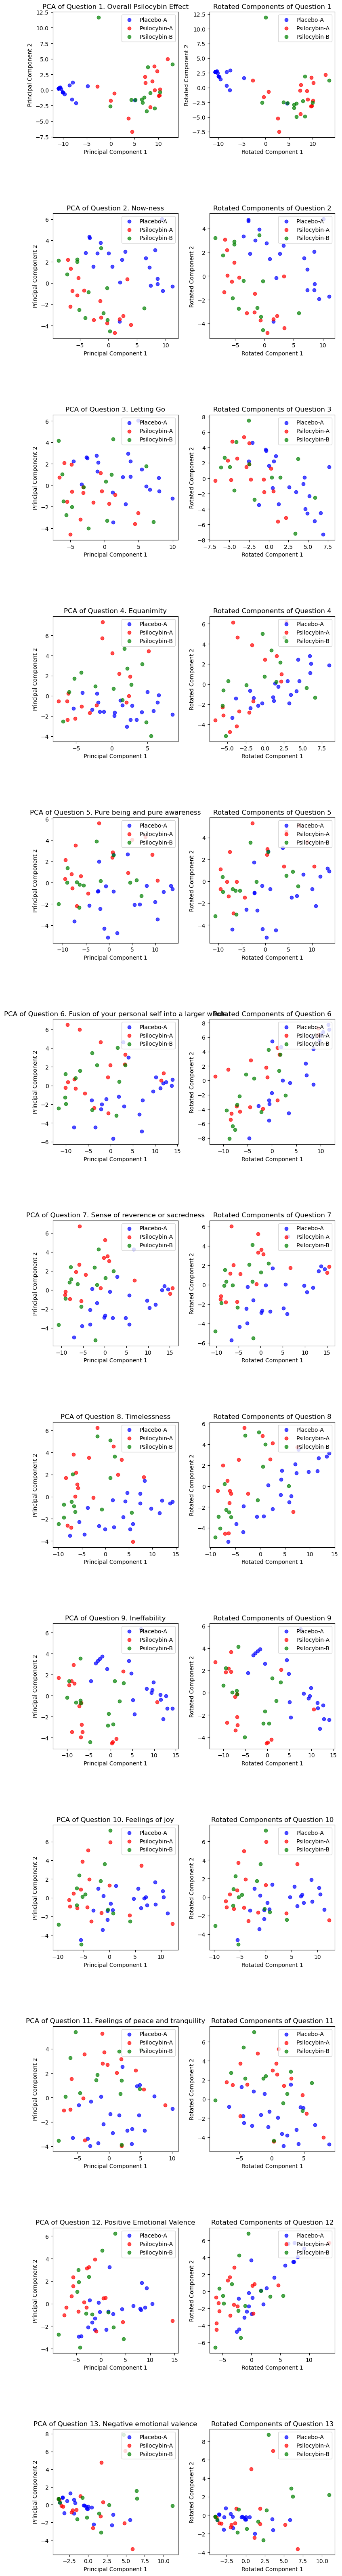

In [18]:
# visualize rotated_components
# Perform Varimax rotation
rotator = Rotator(method='varimax')
pca_result_list = []
rotation_result_list = []


# Create a figure with subplots
fig, axes = plt.subplots(13, 2, figsize=(8, 65))  # 13 rows, 1 column

# Loop through each question (feature)
for i in range(13):
    # Extract data for the current question
    data = feature_reshaped[i]

    # Perform PCA on features
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    rotated_components = rotator.fit_transform(pca_result)

    # Store the results
    pca_result_list.append(pca_result)
    rotation_result_list.append(rotated_components)

    ###############################
    # Plot for features (left side)
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i, 0].scatter(pca_result[indices, 0], pca_result[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i, 0].set_title(f'PCA of Question {questions[i]}')
    axes[i, 0].set_xlabel('Principal Component 1')
    axes[i, 0].set_ylabel('Principal Component 2')
    axes[i, 0].legend(loc='upper right')
    axes[i,0].set_box_aspect(1)

    ##############################
    # Plot for rotated components
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i,1].scatter(rotated_components[indices, 0], rotated_components[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i,1].set_title(f'Rotated Components of Question {i+1}')
    axes[i,1].set_xlabel('Rotated Component 1')
    axes[i,1].set_ylabel('Rotated Component 2')
    axes[i,1].set_box_aspect(1)

    # Remove duplicate labels from legend
    handles, labels = axes[i,1].get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    axes[i,1].legend(unique_handles, unique_labels, loc='upper right')



# Adjust layout and show the figure
plt.tight_layout()
plt.show()

In [19]:
from factor_analyzer import Rotator

# Perform Varimax rotation
rotator = Rotator(method='varimax')
rotated_components = rotator.fit_transform(pca_result)

In [20]:
rotated_components.shape

(50, 2)

Accuracy for Question 1 (PLA classification): 0.94
Accuracy for Question 2 (PLA classification): 0.74
Accuracy for Question 3 (PLA classification): 0.74
Accuracy for Question 4 (PLA classification): 0.74
Accuracy for Question 5 (PLA classification): 0.66
Accuracy for Question 6 (PLA classification): 0.74
Accuracy for Question 7 (PLA classification): 0.66
Accuracy for Question 8 (PLA classification): 0.78
Accuracy for Question 9 (PLA classification): 0.78
Accuracy for Question 10 (PLA classification): 0.72
Accuracy for Question 11 (PLA classification): 0.64
Accuracy for Question 12 (PLA classification): 0.70
Accuracy for Question 13 (PLA classification): 0.62


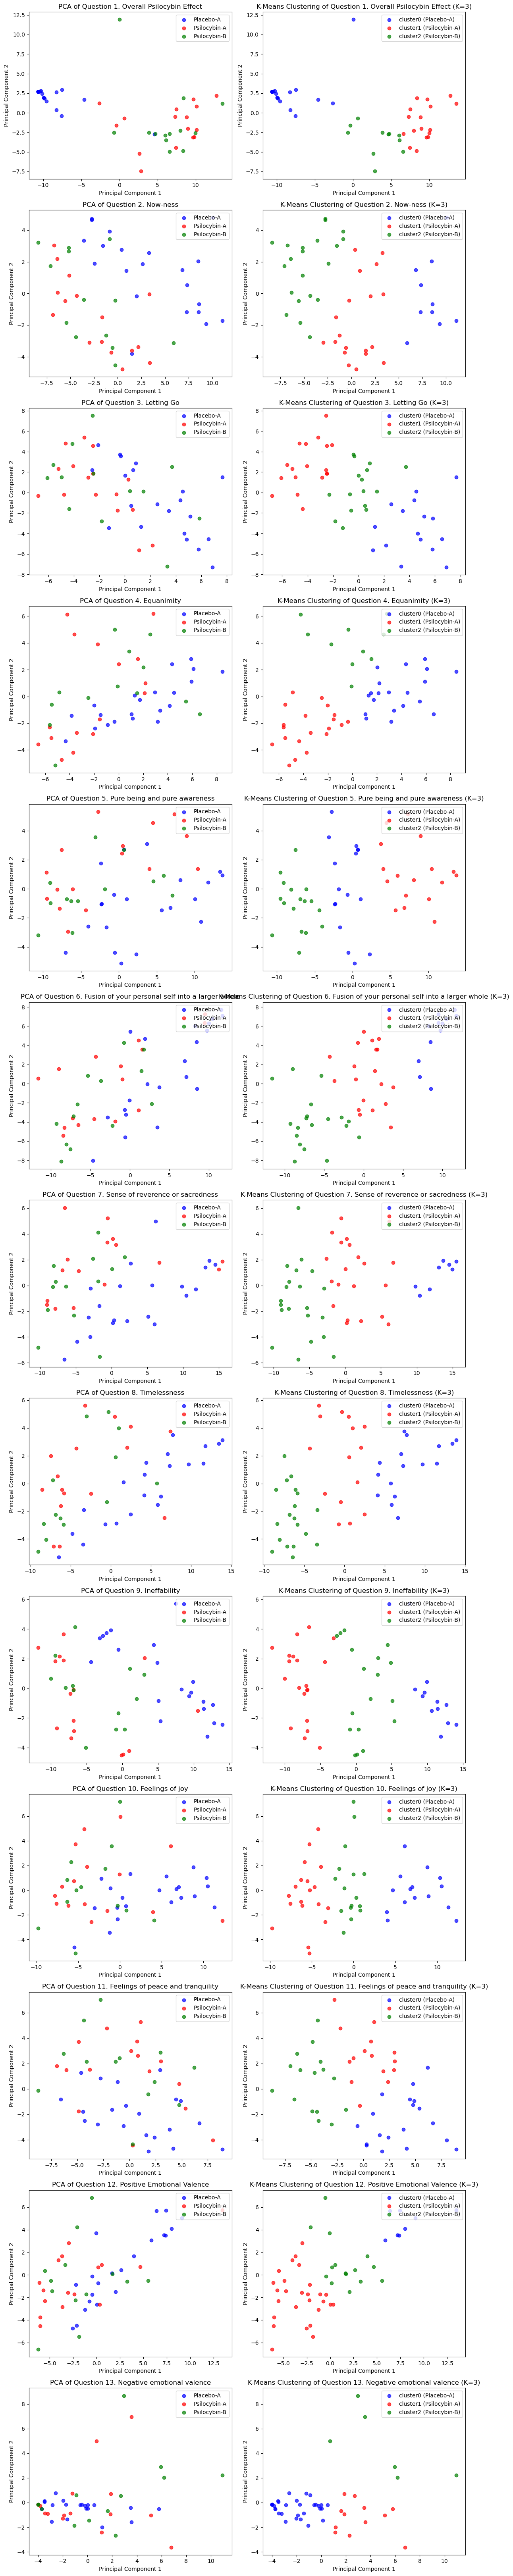

[0.94, 0.74, 0.74, 0.74, 0.66, 0.74, 0.66, 0.78, 0.78, 0.72, 0.64, 0.7, 0.62]

In [21]:
# Perform pca and k-means (k=3) clustering. Plot pca, 'PLA' class in blue, and 'EXP'+'PSIL' in red.  After k-means clustering, make a rotation for each cluster matching each class (class1 PLA, class2: EXP, class3: PSIL) to find the best match that has highest classifying accuracy. Then, plot the k-means clustering, the color should be the same as pca plot, with reference of best match. Then, calculate the accuracy for each question's classification (the cluster matches PLA, and combine the other two clusters to match EXP+PSIL)
# palette = {'Placebo-A': 'blue', 'Psilocybin-A': 'red', 'Psilocybin-B': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(13, 2, figsize=(12, 65))  # 13 rows, 2 columns
accuracies_rotation = []
# Loop through each question (feature)
for i in range(13):
    
    pca_result = rotation_result_list[i]

    # Plot for features (left side)
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i, 0].scatter(pca_result[indices, 0], pca_result[indices, 1],
                           c=palette[condition], label=condition, alpha=0.7)

    axes[i, 0].set_title(f'PCA of Question {questions[i]}')
    axes[i, 0].set_xlabel('Principal Component 1')
    axes[i, 0].set_ylabel('Principal Component 2')
    axes[i, 0].legend(loc='upper right')

    # Perform K-Means clustering on PCA result of features_interplot
    n_clusters = 3  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(pca_result)

    # Find the best match for cluster labels to conditions (PLA, EXP, PSIL)
    best_accuracy = 0
    best_mapping = None
    for mapping in [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]:
        predicted_labels = np.where(clusters == mapping[0], 'Placebo-A',
                                    np.where(clusters == mapping[1], 'Psilocybin-B', 'Psilocybin-A'))
        accuracy = accuracy_score(condition_reshaped, predicted_labels)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mapping = mapping

    # Plot K-means clusters (right side) with best mapping
    if best_mapping:
        predicted_labels = np.where(clusters == best_mapping[0], 'Placebo-A',
                                    np.where(clusters == best_mapping[1], 'Psilocybin-B', 'Psilocybin-A'))
        for label in np.unique(predicted_labels):
            indices = np.where(predicted_labels == label)[0]
            axes[i, 1].scatter(pca_result[indices, 0], pca_result[indices, 1],
                               c=palette[label], label=label, alpha=0.7)

    axes[i, 1].set_title(f'K-Means Clustering of Question {questions[i]} (K=3)')
    axes[i, 1].set_xlabel('Principal Component 1')
    axes[i, 1].set_ylabel('Principal Component 2')


    # Calculate accuracy for PLA classification (cluster matches PLA, combine other two clusters to match EXP+PSIL)
    if best_mapping:
        predicted_labels = np.where(clusters == best_mapping[0], 'Placebo-A', 'Psilocybin-A+B')
        accuracy = accuracy_score(np.where(condition_reshaped == 'Placebo-A', 'Placebo-A', 'Psilocybin-A+B'), predicted_labels)
        print(f"Accuracy for Question {i+1} (PLA classification): {accuracy:.2f}")
    accuracies_rotation.append(accuracy)
    # axes[i, 2].text(0.5, 0.5, f'Accuracy: {accuracy:.2f}', ha='center', va='center')
    # axes[i, 2].axis('off')

    # Add legend for clusters
    handles, labels = axes[i, 1].get_legend_handles_labels()
    unique_labels = ['cluster0 (Placebo-A)','cluster1 (Psilocybin-A)', 'cluster2 (Psilocybin-B)']
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            #unique_labels.append(label)
            unique_handles.append(handle)
    axes[i, 1].legend(unique_handles, unique_labels, loc='upper right')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()
accuracies_rotation


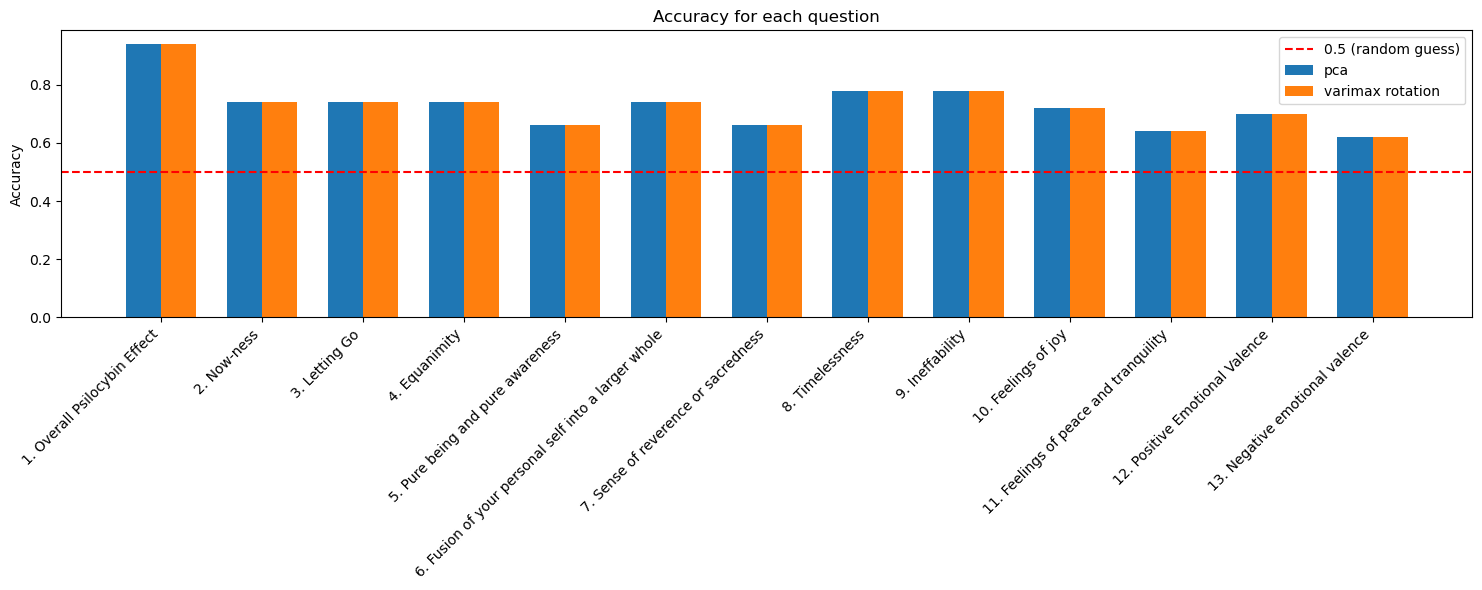

In [22]:
# Plot the accuracies for each question contained in list question. accuracy scores stored in accuracies2 and accuracies3. plot them in bar graphs. Legend set score in accuracies2 as k=2, accuracies3 as k=3, draw a threshold line at 0.58

x = np.arange(len(questions))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust figure size as needed
# rects1 = ax.bar(x - width*4/3, accuracies2, width, label='k=2')
rects2 = ax.bar(x - width / 2, accuracies3, width, label='pca')
rects3 = ax.bar(x + width / 2, accuracies_rotation, width, label='varimax rotation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for each question')
ax.set_xticks(x, questions, rotation=45, ha='right')


# Add a horizontal line at 0.58
ax.axhline(y=0.50, color='red', linestyle='--', label='0.5 (random guess)')

ax.legend()

# Adjust layout and show the figure
fig.tight_layout()
plt.show()

# **PCA over time**

## Perform PCA to reduce dimension (13 question to 2/3 principle components)

In [23]:
condition_reshaped

array(['Placebo-A', 'Placebo-A', 'Placebo-A', 'Psilocybin-A',
       'Psilocybin-B', 'Placebo-A', 'Psilocybin-A', 'Psilocybin-B',
       'Placebo-A', 'Psilocybin-A', 'Placebo-A', 'Psilocybin-A',
       'Placebo-A', 'Psilocybin-A', 'Psilocybin-B', 'Psilocybin-B',
       'Placebo-A', 'Psilocybin-A', 'Psilocybin-B', 'Placebo-A',
       'Psilocybin-B', 'Placebo-A', 'Psilocybin-A', 'Placebo-A',
       'Psilocybin-A', 'Psilocybin-B', 'Placebo-A', 'Psilocybin-A',
       'Psilocybin-B', 'Psilocybin-B', 'Psilocybin-B', 'Placebo-A',
       'Psilocybin-A', 'Placebo-A', 'Psilocybin-B', 'Placebo-A',
       'Psilocybin-A', 'Psilocybin-B', 'Placebo-A', 'Psilocybin-A',
       'Placebo-A', 'Psilocybin-A', 'Placebo-A', 'Psilocybin-A',
       'Placebo-A', 'Psilocybin-A', 'Placebo-A', 'Placebo-A',
       'Psilocybin-A', 'Psilocybin-B'], dtype='<U12')

In [24]:
def update_features():
    # Assuming condition_reshaped is a 1D array of shape (50,)
    # and feature_reshaped is a 3D array of shape (13, 50, 8)

    # Step 1: Identify indices of individuals in the Psilocybin-B group
    psilocybin_b_indices = np.where(condition_reshaped == 'Psilocybin-B')[0]

    # Step 2: Create a mask for filtering
    mask = np.isin(np.arange(condition_reshaped.shape[0]), psilocybin_b_indices, invert=True)

    # Step 3: Update condition_reshaped
    condition_reshaped = condition_reshaped[mask]

    # Step 4: Update feature_reshaped
    # Since feature_reshaped has shape (13, 50, 8), we need to filter along the second dimension (individuals)
    feature_reshaped = feature_reshaped[:, mask, :]

    # Now condition_reshaped and feature_reshaped have been updated
    print("Updated condition_reshaped shape:", condition_reshaped.shape)
    print("Updated feature_reshaped shape:", feature_reshaped.shape)
if_pairwise = False
if if_pairwise:
    update_features()

In [25]:
# Create a figure with subplots
#fig, axes = plt.subplots(feature_reshaped.shape[2], 1, figsize=(8, 65))  # One row for each time point
pca_over_time = []

# Loop through each time point
for t in range(feature_reshaped.shape[2]):
    # Extract data for the current time point
    data = feature_reshaped[:, :, t].transpose()

    # Perform PCA on the extracted data
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    pca_over_time.append(pca_result)

##############################################
## uncomment following to visualize 2d pca of each time point
##############################################

#     # Plot the PCA results
#     for condition in np.unique(condition_reshaped):
#         indices = np.where(condition_reshaped == condition)[0]
#         axes[t].scatter(pca_result[indices, 0], pca_result[indices, 1],
#                         c=palette[condition], label=condition, alpha=0.7)

#     axes[t].set_title(f'PCA at Time Point {t}')
#     axes[t].set_xlabel('Principal Component 1')
#     axes[t].set_ylabel('Principal Component 2')
#     axes[t].legend(loc='upper right')

# # Adjust layout and show the figure
# plt.tight_layout()
# plt.show()


In [26]:
pca_over_time = np.array(pca_over_time)
pca_over_time.shape

(8, 50, 3)

## 3d plot

In [27]:

# time array for axis labeling
time = np.array([-20, 60, 120, 180, 240, 300, 360])
time

array([-20,  60, 120, 180, 240, 300, 360])

In [28]:
pca_over_time.shape

(8, 50, 3)

## PCA (1 principle component) over time

In [29]:
fig = go.Figure()

# Loop through each subject
for subject_id in range(pca_over_time.shape[1]):
    ys = []
    
    # Loop through each time point
    for t in range(pca_over_time.shape[0]):
        pca_result = pca_over_time[t]
        ys.append(pca_result[subject_id, 0])  # Principal Component 1
    
    # Determine the condition for each subject using the reshaped condition array
    condition = condition_reshaped[subject_id]
    
    # Add the subject's trajectory over time to the 2D plot
    fig.add_trace(go.Scatter(
        x=np.unique(timepoints),
        y=ys,
        mode='lines',  # Line plot without markers
        line=dict(color=palette[condition]),
        showlegend=False  # Hide individual subject legends
    ))

# Add separate traces for each condition to show in legend only
for condition, color in palette.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],  # No data, just for legend
        mode='lines',
        line=dict(color=color),
        name=condition
    ))

# Set labels
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Principal Component 1',
    title='Principal Component 1 Over Time for Each Subject'
)

# Show the plot
fig.show()


Plot the average of trajectories

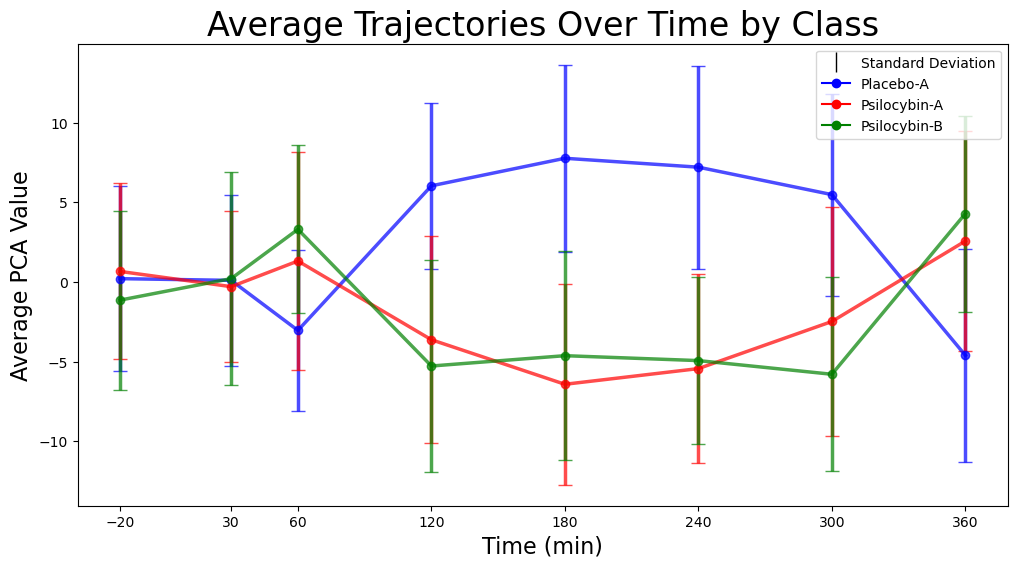

In [30]:
# Assuming pca_over_time has shape (8, 50, 1)
# and condition_reshaped has shape (50,) with classes ['Placebo-A', 'Psilocybin-A', 'Psilocybin-B']

# Squeeze pca_over_time to remove the singleton dimension
pca_component_1 = pca_over_time[:, :, 0]

# Initialize arrays to hold mean and std deviation for each class
classes = np.unique(condition_reshaped)
mean_trajectories = np.zeros((8, len(classes)))
std_trajectories = np.zeros((8, len(classes)))

# Calculate mean and std for each class at each time point
for i, cls in enumerate(classes):
    class_indices = np.where(condition_reshaped == cls)[0]
    mean_trajectories[:, i] = np.mean(pca_component_1[:, class_indices], axis=1)
    std_trajectories[:, i] = np.std(pca_component_1[:, class_indices], axis=1)

# Define the time points
time_points = np.unique(timepoints)

# Plotting the average trajectories with error bars
plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes):
    plt.errorbar(time_points, mean_trajectories[:, i], 
                 yerr=std_trajectories[:, i], 
                 label=cls, 
                 capsize=5, 
                 marker='o', 
                 linestyle='-', 
                 color=palette[cls],  # Use the defined palette
                 linewidth=2.5,
                 alpha=0.7)

# Creating custom legend entries for mean and standard deviation
mean_legend_line = Line2D([0], [0], color='black', marker='o', linestyle='-', linewidth=1.5, label='Mean')
std_legend_line = Line2D([0], [0], color='black', marker='|', markersize=15, linestyle='', linewidth=1.5, label='Standard Deviation')

# Adding custom legends for each class and standard deviation
plt.legend(handles=[std_legend_line] + 
           [Line2D([0], [0], marker='o', color=palette[cls], label=cls) for cls in classes], loc='upper right')

# Customize title and axis labels
plt.title('Average Trajectories Over Time by Class', fontsize=24)
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Average PCA Value', fontsize=16)
plt.xticks(time_points)
plt.show()


## PCA (2 principle components) over time

In [31]:
# Create a 3D figure
fig = go.Figure()

# Loop through each subject
for subject_id in range(pca_over_time.shape[1]):
    xs = []
    ys = []
    zs = timepoints  # Use the time array as the y-axis values
    
    # Loop through each time point
    for t in range(pca_over_time.shape[0]):
        pca_result = pca_over_time[t]
        xs.append(pca_result[subject_id, 0])  # Principal Component 1
        ys.append(pca_result[subject_id, 1])  # Principal Component 2
    
    # Determine the condition for each subject using the reshaped condition array
    condition = condition_reshaped[subject_id]
    
    # Add the subject's trajectory over time to the plot without showing legend for each subject
    fig.add_trace(go.Scatter3d(
        x=xs, 
        y=zs, 
        z=ys, 
        mode='lines',  # Remove dots
        line=dict(color=palette[condition]),
        showlegend=False  # Hide individual subject legends
    ))

# Add separate traces for each condition to show in legend only
for condition, color in palette.items():
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],  # No data, just for legend
        mode='lines',
        line=dict(color=color),
        name=condition
    ))

# Set labels
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Time',
        zaxis_title='Principal Component 2'
    ),
    title='PCA Over Time for Each Subject'
)

# Show the plot
fig.show()


## 3 components, abstract time space

In [32]:
import plotly.graph_objects as go

# Define the color palette for each condition
palette = {
    'Placebo-A': 'blue', 
    'Psilocybin-A': 'red', 
    'Psilocybin-B': 'green'
}

# Create a 3D figure
fig = go.Figure()

# Add a single trace per condition to serve as the legend entry
for condition, color in palette.items():
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='lines',
        line=dict(color=color),
        name=condition  # Only this will show in the legend
    ))

# Loop through each subject to add their trajectory without markers
for subject_id in range(pca_over_time.shape[1]):
    xs = []
    ys = []
    zs = []
    
    # Loop through each time point
    for t in range(pca_over_time.shape[0]):
        pca_result = pca_over_time[t]
        xs.append(pca_result[subject_id, 0])
        ys.append(pca_result[subject_id, 1])
        zs.append(pca_result[subject_id, 2])
    
    # Get the color for the subject based on their condition
    condition = condition_reshaped[subject_id]
    color = palette[condition]
    
    # Add the subject's trajectory over time to the plot without showing in legend and without markers
    fig.add_trace(go.Scatter3d(
        x=xs, 
        y=zs, 
        z=ys, 
        mode='lines',  # Only lines, no markers
        line=dict(color=color),
        showlegend=False  # Prevent subject traces from appearing in the legend
    ))

# Set axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    title='PCA Over Time for Each Subject'
)

# Show the plot
fig.show()


# Qutantify pca over time

In [33]:
from scipy.spatial.distance import pdist, squareform


In [34]:
# Initialize the explained variance matrix (8 time points x 3 classes)
explained_variance_matrix = np.zeros((8, 3))

# Loop through each time point
for t in range(8):
    # Loop through each class
    for i, cls in enumerate(classes):
        # Get indices of individuals in the current class
        class_indices = np.where(condition_reshaped == cls)[0]
        
        # Extract data for the current time point and class
        class_data = pca_over_time[t, class_indices, :]  # Shape should be (n_individuals_in_class, 2)
        
        # Perform PCA on the data for this time point and class
        pca = PCA()
        pca.fit(class_data)
        
        # Calculate the explained variance ratio for the first principal component
        explained_variance_matrix[t, i] = pca.explained_variance_ratio_[0]

# Output the explained variance matrix
print(classes)
print("Explained Variance Matrix (8x3):")
print(explained_variance_matrix)

['Placebo-A' 'Psilocybin-A' 'Psilocybin-B']
Explained Variance Matrix (8x3):
[[0.79963363 0.76292393 0.80288534]
 [0.80179516 0.51480561 0.78219714]
 [0.81516378 0.6633856  0.69062473]
 [0.75848543 0.69957163 0.86191936]
 [0.86431402 0.83217324 0.70787276]
 [0.90957828 0.71236085 0.76306429]
 [0.89668341 0.77154855 0.78643332]
 [0.83725794 0.77684749 0.7853144 ]]


## Pairwise distance

In [35]:

# Count the number of unique classes in condition_reshaped
unique_classes, counts = np.unique(condition_reshaped, return_counts=True)

# Print the results
for cls, count in zip(unique_classes, counts):
    print(f"Class '{cls}': {count} instances")

Class 'Placebo-A': 21 instances
Class 'Psilocybin-A': 16 instances
Class 'Psilocybin-B': 13 instances


In [36]:

# Assuming pca_over_time has shape (8, 50, 2)
# and condition_reshaped has shape (50,) with classes ['Placebo-A', 'Psilocybin-A', 'Psilocybin-B']

# Define classes of interest
class_a = 'Placebo-A'
class_b = 'Psilocybin-A'

# Initialize a list to hold the mean pairwise distance for each time point
mean_distances = []
n = 3   # Number of dimensions to consider

# Loop through each time point
for t in range(8):
    # Get indices of individuals in each class
    indices_a = np.where(condition_reshaped == class_a)[0]
    indices_b = np.where(condition_reshaped == class_b)[0]
    
    ############# n dimensions #############
    # Extract PCA points for the current time point for each class
    data_a = pca_over_time[t, indices_a, :n]  # Shape (num_a, 2)
    data_b = pca_over_time[t, indices_b, :n]  # Shape (num_b, 2)
    
    # Compute pairwise distances between individuals in Placebo-A and Psilocybin-A
    dist_matrix = pairwise_distances(data_a, data_b, metric='euclidean')
    
    # Calculate the mean distance for this time point
    mean_distance = dist_matrix.mean()
    mean_distances.append(mean_distance)

# Output the mean distances for each time point
print("Mean Pairwise Distances at Each Time Point:", mean_distances)


Mean Pairwise Distances at Each Time Point: [8.276808593579414, 8.161628186556303, 11.271039281303514, 14.308876566755506, 16.83028932114963, 15.394614598941939, 12.359770895968149, 11.899844094248579]


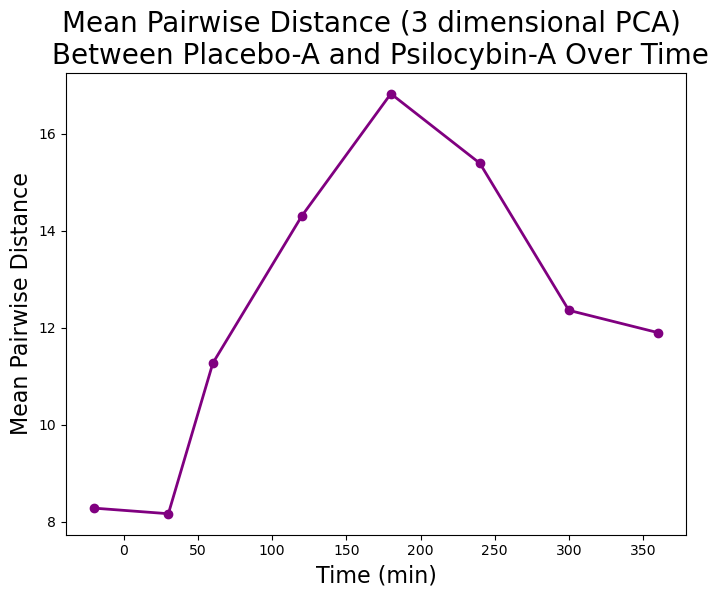

In [37]:

#time_points = np.array([-20, 60, 120, 180, 240, 300, 360])  # Define your time points here

plt.figure(figsize=(8, 6))
plt.plot(time_points, mean_distances, marker='o', linestyle='-', color='purple', linewidth=2)

# Add labels and title
plt.title(f"Mean Pairwise Distance ({n} dimensional PCA) \n Between Placebo-A and Psilocybin-A Over Time", fontsize=20)
plt.xlabel("Time (min)", fontsize=16)
plt.ylabel("Mean Pairwise Distance", fontsize=16)
#plt.grid(True)

# Show the plot
plt.show()

## multi dimensional scaling

Individual features shape: (50, 104)
 distance matrix shape: (50, 50)


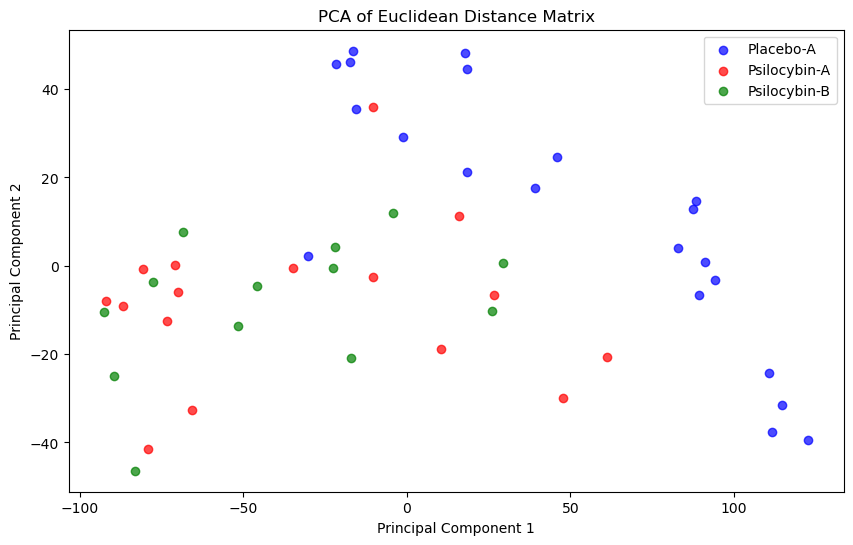

In [38]:

from sklearn.metrics import pairwise_distances


# Assuming feature_reshaped is a (13, 50, 8) numpy matrix and condition_reshaped is defined
# Reshape feature_reshaped to (50, 13*8) to treat each individual as a single vector
#individual_features = feature_reshaped.reshape(50, -1)
individual_features = feature_reshaped.transpose(1, 0, 2).reshape(50, 13 * 8)
print(f'Individual features shape: {individual_features.shape}')

# Calculate the Euclidean distance between each pair of individuals
distance_matrix = pairwise_distances(individual_features, metric='euclidean')
print(f' distance matrix shape: {distance_matrix.shape}')

# Perform PCA on the entire 50x50 distance matrix
pca = PCA(n_components=3)
pca_result = pca.fit_transform(distance_matrix)

# Plotting PCA results
plt.figure(figsize=(10, 6))

# Plot for features based on conditions
for condition in np.unique(condition_reshaped):
    indices = np.where(condition_reshaped == condition)[0]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1],
                color=palette[condition], label=condition, alpha=0.7)

# Instead of using an undefined index `i`, you may want to provide a fixed question or indicate it's from a specific context
plt.title('PCA of Euclidean Distance Matrix')  # Or specify a question if needed
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper right')
#plt.grid()
plt.show()


In [39]:
individual_features.shape

(50, 104)

### plot in 3d

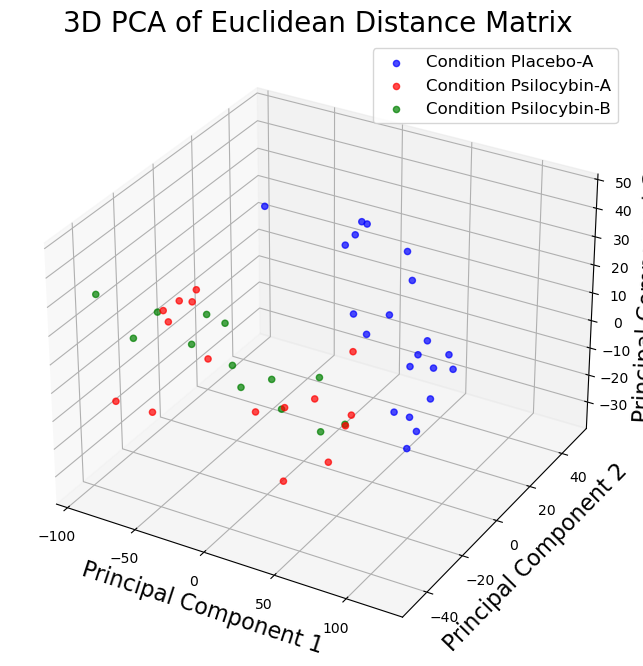

In [40]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot for features based on conditions
for condition in np.unique(condition_reshaped):
    indices = np.where(condition_reshaped == condition)[0]
    ax.scatter(pca_result[indices, 0], pca_result[indices, 1], pca_result[indices, 2],
               color=palette[condition], label=f'Condition {condition}', alpha=0.7)

# Set titles and labels
ax.set_title('3D PCA of Euclidean Distance Matrix', fontsize=20)
ax.set_xlabel('Principal Component 1', fontsize=16)
ax.set_ylabel('Principal Component 2', fontsize=16)
ax.set_zlabel('Principal Component 3', fontsize=16)
ax.legend(loc='upper right', fontsize=12)

plt.show()

In [41]:
import plotly.express as px

# Prepare data for Plotly
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
df_pca['Condition'] = condition_reshaped  # Add conditions for coloring

# Create an interactive 3D scatter plot
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='Condition',
                    title='3D PCA of Euclidean Distance Matrix',
                    color_discrete_sequence=px.colors.qualitative.Set1)

# Show the plot
fig.show()

## PCA of PCA

Principal Component 1, PCA explained variance ratio: [0.79153798 0.13401559]
Principal Component 2, PCA explained variance ratio: [0.62525508 0.23200508]
Principal Component 3, PCA explained variance ratio: [0.52999014 0.18881309]


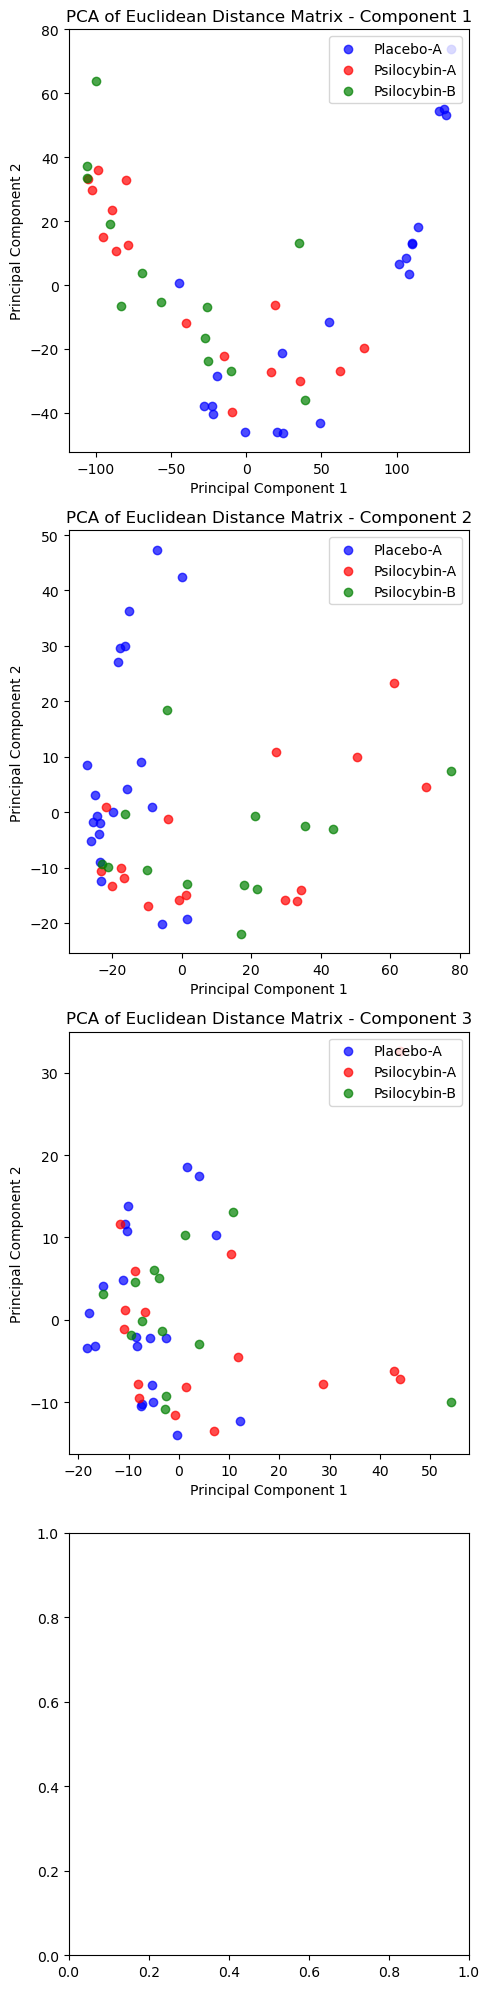

In [42]:
fig, axes = plt.subplots(4, 1, figsize=(5, 20))  # 4 rows, 1 column for subplots

for i in range(3):
    # Extract the PCA results for the specific component over time
    pca_result = pca_over_time[:, :, i]
    
    # Calculate the pairwise distances between subjects at this component
    distance_matrix = squareform(pdist(pca_result.T, metric='euclidean'))
    
    # Perform PCA on the distance matrix
    pca = PCA(n_components=2)
    transformed_result = pca.fit_transform(distance_matrix)
    
    # Print the explained variance ratio for each principal component
    print(f'Principal Component {i+1}, PCA explained variance ratio: {pca.explained_variance_ratio_}')
    
    # Plot the PCA-transformed distance matrix results
    for condition in np.unique(condition_reshaped):
        indices = np.where(condition_reshaped == condition)[0]
        axes[i].scatter(transformed_result[indices, 0], transformed_result[indices, 1],
                        c=palette[condition], label=condition, alpha=0.7)
    
    axes[i].set_title(f'PCA of Euclidean Distance Matrix - Component {i+1}')
    axes[i].set_xlabel('Principal Component 1')
    axes[i].set_ylabel('Principal Component 2')
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()